In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from src.polaris import Polaris
from src.data import PolarisDataset
from src.utils import scaffold_split
from pathlib import Path
import seaborn as sns
import polaris as po
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

# set seaborn theme
sns.set_theme()

# Data Evaluation

## Potency

### Datasets

Show label distribution for Train Polaris, Train Scaffold, Test Scaffold
Also show number of duplicate entries



In [ ]:
task = 'potency'
target_task = 'pIC50 (MERS-CoV Mpro)'

root = Path("./data") / "polaris" / task
train_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=True)
test_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=False)
train_scaffold, test_scaffold = scaffold_split(dataset=train_polaris, test_size=0.1)

In [ ]:
train_plot = sns.displot(data=train_polaris.y, kde=True, legend=False)
train_plot.set_xlabels(target_task)
plt.title("Train Polaris")
sns.displot(data=train_scaffold.y, kde=True, legend=False).set_xlabels(target_task)
plt.title("Train Scaffold")
sns.displot(data=test_scaffold.y, kde=True, legend=False).set_xlabels(target_task)
plt.title("Test Scaffold")

### Inference

In [2]:
# Combine results of gnn and ecfp
df_potency_gnn = pd.read_csv("./results/potency_gnn_results.csv")
df_potency_ecfp = pd.read_csv("./results/potency_ecfp_results.csv")
df_potency = pd.concat([df_potency_gnn, df_potency_ecfp]).reset_index(drop=True)
df_potency = df_potency.convert_dtypes()
df_potency

,task,target_task,batch_size,epochs,lr,num_cv_folds,num_cv_bins,scaffold_split_val_sz,repr_model,in_channels,hidden_channels,out_channels,num_layers,dropout,proj_hidden_dim,out_dim,mean_val_loss,patience,final_avg_epochs,radius
0,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GIN,9,64,64,3,0.1,64,1,1.115454,5,21,<NA>
1,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GAT,9,64,64,3,0.1,64,1,1.114393,5,23,<NA>
2,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GCN,9,64,64,3,0.1,64,1,1.124692,5,17,<NA>
3,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,GraphSAGE,9,64,64,3,0.1,64,1,1.14815,5,21,<NA>
4,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,GIN,9,64,64,3,0.1,64,1,0.953295,5,30,<NA>
5,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,GAT,9,64,64,3,0.1,64,1,1.149814,5,14,<NA>
6,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,GCN,9,64,64,3,0.1,64,1,1.024901,5,17,<NA>
7,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,GraphSAGE,9,64,64,3,0.1,64,1,1.116246,5,16,<NA>
8,potency,pIC50 (MERS-CoV Mpro),32,500,0.001,5,10,0.1,ECFP,<NA>,<NA>,1024,<NA>,<NA>,64,1,0.921941,5,10,2
9,potency,pIC50 (SARS-CoV-2 Mpro),32,500,0.001,5,10,0.1,ECFP,<NA>,<NA>,1024,<NA>,<NA>,64,1,0.533963,5,18,2


In [ ]:
# Group by target_task and find the row with minimum mean_val_loss for each group
best_models_potency = df_potency.loc[df_potency.groupby(['target_task', 'repr_model'])['mean_val_loss'].idxmin()].reset_index(drop=True)
best_models_potency_list = best_models_potency.to_dict('records')
best_models_potency_list

In [ ]:
# Iterate over each model, then
# 1. Train model on train_scaffold.
# 2. Make predictions on test_scaffold
# 3. Predict MAE

test_scaffold_potency_preds = {}

for model in best_models_potency_list:
  target_task = model['target_task']
  polaris = Polaris(params=model)
  polaris.train_final(polaris.train_scaffold)
  preds = polaris.predict(polaris.test_scaffold)
  preds = [pred[1] for pred in preds]
  mae = mean_absolute_error(preds, polaris.test_scaffold.y)
  print(mae)
  d = {model['repr_model']: mae}
  test_scaffold_potency_preds.setdefault(target_task, {}).update(d)

test_scaffold_potency_preds

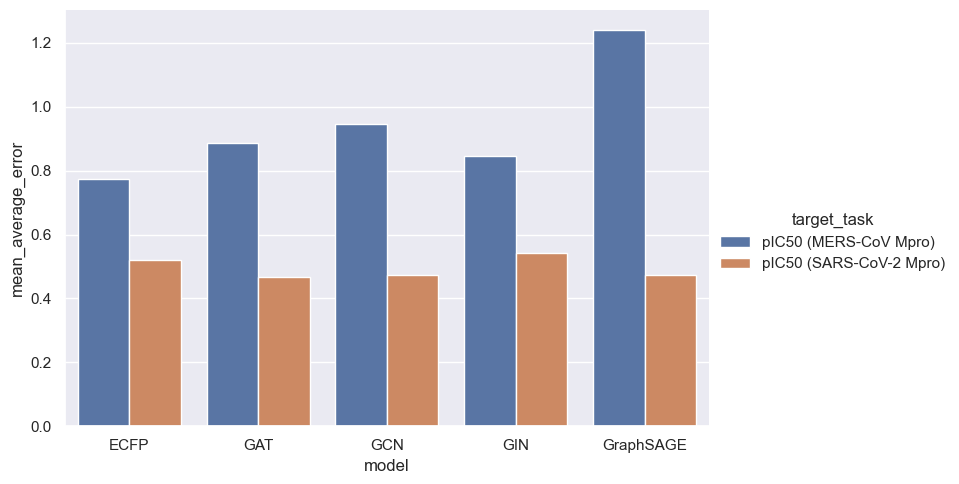

In [5]:
# Create a histogram of MAE for each target_task and model
df_potency_hist = pd.DataFrame(test_scaffold_potency_preds)
df_potency_hist = df_potency_hist.reset_index().melt(id_vars="index", var_name="target_task", value_name="mean_average_error")
df_potency_hist.rename(columns={"index": "model"}, inplace=True)
g = sns.catplot(
    data=df_potency_hist,
    kind="bar",
    x="model",
    y="mean_average_error",
    hue="target_task",
    aspect=1.5,
)

### Analysis

In [ ]:
# Plot y_true, y_pred for best performing model (maybe even in plotly?)

### Submission

In [6]:
# Pick best model for each task
# TODO: Write a function for this
potency_submission_models_list = [best_models_potency_list[0], best_models_potency_list[5]]

y_pred = {}
for model in potency_submission_models_list:
	target_task = model["target_task"]
	polaris = Polaris(model)
	polaris.train_final(polaris.train_polaris)
	preds = polaris.predict(polaris.test_polaris)
	y_pred[target_task] = preds

y_submission = {}
for k, v in y_pred.items():
	y_submission[k] = [tup[1] for tup in v]

Processing...
Done!
Processing...
Done!
100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
Processing...
Done!
Processing...
Done!
100%|██████████| 18/18 [00:34<00:00,  1.93s/it]


In [7]:
# Submit results
competition = po.load_competition("asap-discovery/antiviral-potency-2025")

competition.submit_predictions(
    predictions = y_submission,
    prediction_name = "test_2",
    prediction_owner = "aehrlich",
    report_url = "https://www.example.com",
    description = "Second submission"
)

[2025-03-06 18:21:08] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=982095;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=836503;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=153482;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=352863;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

Output()

[18:21:09]  Success: Submitting competition predictions                                               ]8;id=593644;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=811655;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

## Admet

### Datasets

In [2]:
task = 'admet'
target_task = 'MDR1-MDCKII'

root = Path("./data") / "polaris" / task
train_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=True)
test_polaris = PolarisDataset(root=root, task=task, target_task=target_task, train=False)
train_scaffold, test_scaffold = scaffold_split(dataset=train_polaris, test_size=0.1)

Processing...
Done!
Processing...
Done!


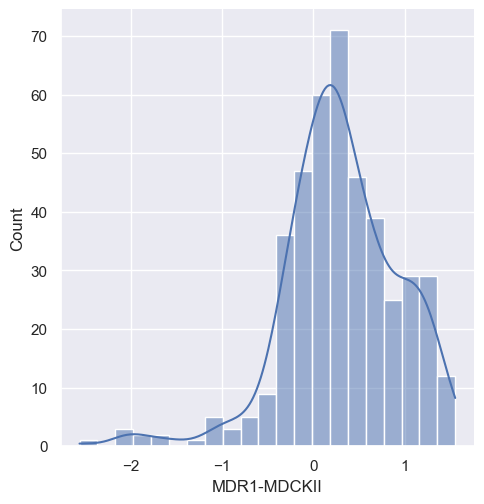

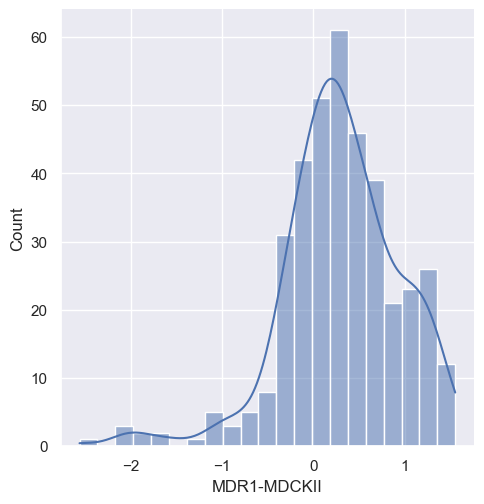

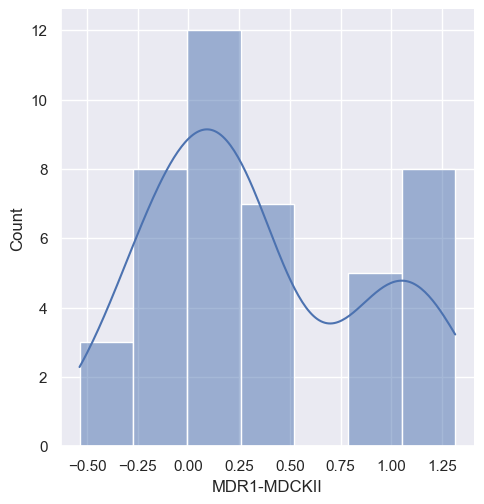

In [3]:
sns.displot(data=train_polaris.y, kde=True, legend=False).set_xlabels(target_task)
sns.displot(data=train_scaffold.y, kde=True, legend=False).set_xlabels(target_task)
sns.displot(data=test_scaffold.y, kde=True, legend=False).set_xlabels(target_task)

### Inference

In [4]:
# Combine results of gnn and ecfp
df_admet_gnn = pd.read_csv("./results/admet_gnn_results.csv")
df_admet_ecfp = pd.read_csv("./results/admet_ecfp_results.csv")
df_admet = pd.concat([df_admet_gnn, df_admet_ecfp]).reset_index(drop=True)
df_admet = df_admet.convert_dtypes()
df_admet


,task,target_task,batch_size,epochs,lr,num_cv_folds,num_cv_bins,scaffold_split_val_sz,repr_model,in_channels,hidden_channels,out_channels,num_layers,dropout,proj_hidden_dim,out_dim,mean_val_loss,patience,final_avg_epochs,radius
0,admet,MLM,32,500,0.001,5,10,0.1,GIN,9,32,64,3,0.1,64,1,0.447329,5,11,<NA>
1,admet,MLM,32,500,0.001,5,10,0.1,GCN,9,32,64,3,0.1,64,1,0.46792,5,12,<NA>
2,admet,MLM,32,500,0.001,5,10,0.1,GAT,9,32,64,3,0.1,64,1,0.473864,5,11,<NA>
3,admet,MLM,32,500,0.001,5,10,0.1,GraphSAGE,9,32,64,3,0.1,64,1,0.475402,5,11,<NA>
4,admet,HLM,32,500,0.001,5,10,0.1,GIN,9,32,64,3,0.1,64,1,0.330356,5,11,<NA>
5,admet,HLM,32,500,0.001,5,10,0.1,GCN,9,32,64,3,0.1,64,1,0.345177,5,16,<NA>
6,admet,HLM,32,500,0.001,5,10,0.1,GAT,9,32,64,3,0.1,64,1,0.345582,5,13,<NA>
7,admet,HLM,32,500,0.001,5,10,0.1,GraphSAGE,9,32,64,3,0.1,64,1,0.341112,5,17,<NA>
8,admet,KSOL,32,500,0.001,5,10,0.1,GIN,9,32,64,3,0.1,64,1,0.533621,5,9,<NA>
9,admet,KSOL,32,500,0.001,5,10,0.1,GCN,9,32,64,3,0.1,64,1,0.565532,5,8,<NA>


In [5]:
# Group by target_task and find the row with minimum mean_val_loss for each group
best_models_admet = df_admet.loc[df_admet.groupby(['target_task', 'repr_model'])['mean_val_loss'].idxmin()].reset_index(drop=True)
best_models_admet_list = best_models_admet.to_dict('records')

In [6]:
test_scaffold_admet_preds = {}

for model in best_models_admet_list:
  target_task = model['target_task']
  polaris = Polaris(params=model)
  polaris.train_final(polaris.train_scaffold)
  preds = polaris.predict(polaris.test_scaffold)
  preds = [pred[1] for pred in preds]
  mae = mean_absolute_error(preds, polaris.test_scaffold.y)
  print(mae)
  d = {model['repr_model']: mae}
  test_scaffold_admet_preds.setdefault(target_task, {}).update(d)

test_scaffold_admet_preds

Processing...
Done!
Processing...
Done!
100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
Processing...


0.5346484203492442


Done!
Processing...
Done!
100%|██████████| 13/13 [00:00<00:00, 17.22it/s]
Processing...
Done!
Processing...
Done!


0.6358174854709256


100%|██████████| 16/16 [00:00<00:00, 23.48it/s]
Processing...
Done!
Processing...
Done!


0.6439096504642118


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]
Processing...
Done!
Processing...
Done!


0.6414209834990963


100%|██████████| 17/17 [00:00<00:00, 26.80it/s]
Processing...
Done!
Processing...


0.6525161362463429


Done!
100%|██████████| 20/20 [00:15<00:00,  1.33it/s]
Processing...


0.4328368708894059


Done!
Processing...
Done!
100%|██████████| 10/10 [00:00<00:00, 14.40it/s]
Processing...
Done!
Processing...


0.47212920962153254


Done!
100%|██████████| 8/8 [00:00<00:00, 19.64it/s]
Processing...
Done!
Processing...


0.5113217315158328


Done!
100%|██████████| 9/9 [00:00<00:00, 19.60it/s]
Processing...
Done!
Processing...


0.5012615886894433


Done!
100%|██████████| 9/9 [00:00<00:00, 21.98it/s]
Processing...
Done!
Processing...


0.5279988630397899


Done!
100%|██████████| 34/34 [00:24<00:00,  1.39it/s]
Processing...


0.8044692401049865


Done!
Processing...
Done!
100%|██████████| 41/41 [00:02<00:00, 15.15it/s]
Processing...
Done!
Processing...


1.011935997236934


Done!
100%|██████████| 17/17 [00:00<00:00, 21.60it/s]
Processing...
Done!
Processing...


1.0683888080012467


Done!
100%|██████████| 26/26 [00:01<00:00, 21.26it/s]
Processing...
Done!
Processing...


1.0345193262522419


Done!
100%|██████████| 32/32 [00:01<00:00, 24.90it/s]
Processing...
Done!
Processing...


0.8197436248883605


Done!
100%|██████████| 12/12 [00:10<00:00,  1.14it/s]
Processing...


0.3788504243590111


Done!
Processing...
Done!
100%|██████████| 37/37 [00:02<00:00, 12.36it/s]
Processing...
Done!
Processing...


0.4373730175023855


Done!
100%|██████████| 9/9 [00:00<00:00, 18.29it/s]
Processing...
Done!
Processing...


0.4856509729180225


Done!
100%|██████████| 18/18 [00:01<00:00, 17.76it/s]
Processing...


0.4355155641949454


Done!
Processing...
Done!
100%|██████████| 25/25 [00:01<00:00, 20.63it/s]
Processing...
Done!
Processing...
Done!


0.48915258361849673


100%|██████████| 22/22 [00:13<00:00,  1.59it/s]
Processing...


0.586446363118387


Done!
Processing...
Done!
100%|██████████| 11/11 [00:00<00:00, 15.30it/s]
Processing...
Done!
Processing...
Done!


0.6687864747739607


100%|██████████| 12/12 [00:00<00:00, 24.46it/s]
Processing...
Done!
Processing...
Done!


0.6760012055596998


100%|██████████| 11/11 [00:00<00:00, 23.38it/s]
Processing...
Done!
Processing...


0.66979571023295


Done!
100%|██████████| 11/11 [00:00<00:00, 28.08it/s]

0.7553691892854629


{'HLM': {'ECFP': 0.5346484203492442,
  'GAT': 0.6358174854709256,
  'GCN': 0.6439096504642118,
  'GIN': 0.6414209834990963,
  'GraphSAGE': 0.6525161362463429},
 'KSOL': {'ECFP': 0.4328368708894059,
  'GAT': 0.47212920962153254,
  'GCN': 0.5113217315158328,
  'GIN': 0.5012615886894433,
  'GraphSAGE': 0.5279988630397899},
 'LogD': {'ECFP': 0.8044692401049865,
  'GAT': 1.011935997236934,
  'GCN': 1.0683888080012467,
  'GIN': 1.0345193262522419,
  'GraphSAGE': 0.8197436248883605},
 'MDR1-MDCKII': {'ECFP': 0.3788504243590111,
  'GAT': 0.4373730175023855,
  'GCN': 0.4856509729180225,
  'GIN': 0.4355155641949454,
  'GraphSAGE': 0.48915258361849673},
 'MLM': {'ECFP': 0.586446363118387,
  'GAT': 0.6687864747739607,
  'GCN': 0.6760012055596998,
  'GIN': 0.66979571023295,
  'GraphSAGE': 0.7553691892854629}}

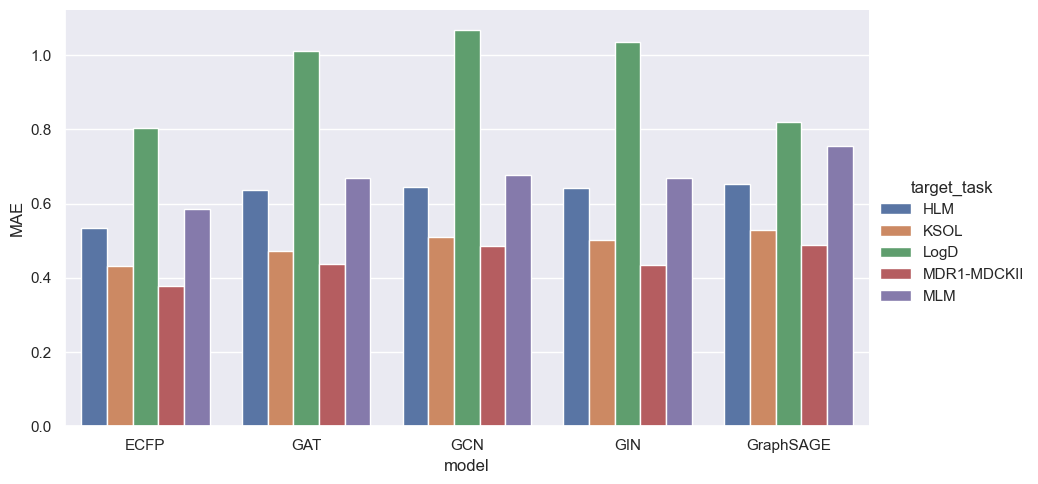

In [ ]:
# Create a histogram of MAE for each target_task and model
df_admet_hist = pd.DataFrame(test_scaffold_admet_preds)
df_admet_hist = df_admet_hist.reset_index().melt(id_vars="index", var_name="target_task", value_name="mean_average_error")
df_admet_hist.rename(columns={"index": "model", "mean_average_error": "MAE"}, inplace=True)
g = sns.catplot(
    data=df_admet_hist,
    kind="bar",
    x="model",
    y="MAE",
    hue="target_task",
    aspect=1.8
)

# TODO: Calculate a predicted MAE when taking the best models out of those.


### Submission

In [ ]:
# Extract the best MAE for each target_task
idx = df_admet_hist.groupby("target_task")['MAE'].idxmin().tolist()
best_models_list_admet = [best_models_admet_list[i] for i in idx]
best_models_list_admet

y_pred = {}
for model in best_models_list_admet:
	target_task = model["target_task"]
	polaris = Polaris(model)
	polaris.train_final(polaris.train_polaris)
	preds = polaris.predict(polaris.test_polaris)
	y_pred[target_task] = preds

y_submission_admet = {}
for k, v in y_pred.items():
	y_submission[k] = [tup[1] for tup in v]

Processing...
Done!
Processing...
Done!
100%|██████████| 14/14 [00:09<00:00,  1.44it/s]
Processing...
Done!
Processing...
Done!
100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
Processing...
Done!
Processing...
Done!
100%|██████████| 34/34 [00:27<00:00,  1.23it/s]
Processing...
Done!
Processing...
Done!
100%|██████████| 12/12 [00:12<00:00,  1.03s/it]
Processing...
Done!
Processing...
Done!
100%|██████████| 22/22 [00:15<00:00,  1.38it/s]


In [ ]:
competition = po.load_competition("asap-discovery/antiviral-admet-2025")

competition.submit_predictions(
    predictions = y_submission_admet,
    prediction_name = "cv-5",
    prediction_owner = "aehrlich",
    report_url = "https://www.example.com",
    description = "Second submission"
)

[2025-03-06 18:39:49] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=98409;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=579538;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.7).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=692644;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=291522;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

[18:39:50]  Success: Submitting competition predictions                                               ]8;id=823782;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=666332;file:///opt/homebrew/Caskroom/miniconda/base/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\